<a href="https://colab.research.google.com/github/hoangvn013-cmd/wound-detection/blob/main/Ai_nh%E1%BA%ADn_di%E1%BB%87n_v%E1%BA%BFt_th%C6%B0%C6%A1ng_v%C3%A0_ph%C3%A2n_lo%E1%BA%A1i.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MINI-PROJECT CUỐI KỲ: NHẬN DẠNG VẾT THƯƠNG (Wound Classification)**

## **Môn học:** Nhập môn Trí tuệ Nhân tạo

***Giai đoạn 1: Chuẩn bị dataset***

**1: Khai báo thư viện & Kết nối Google Drive**

In [4]:
import pandas as pd
import xml.etree.ElementTree as ET
from pathlib import Path
from sklearn.model_selection import train_test_split
from google.colab import drive
from tqdm import tqdm  # Thanh hiển thị tiến trình

# 1. Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# 2. Cấu hình đường dẫn (Sửa lại nếu tên folder của bạn khác)
BASE_DIR = Path('/content/drive/MyDrive/Colab Notebooks/Wound_Project')
IMG_DIR = BASE_DIR / 'imgs'
ANN_DIR = BASE_DIR / 'annotations'
CSV_PATH = BASE_DIR / 'metadata_wound.csv'

# Các đuôi file ảnh chấp nhận
VALID_EXTS = {'.jpg', '.jpeg', '.png', '.bmp'}

# 3. Kiểm tra an toàn
if not IMG_DIR.exists():
    print(f"❌ LỖI TO: Không tìm thấy thư mục ảnh tại: {IMG_DIR}")
    print("👉 Hãy kiểm tra lại đường dẫn trên Google Drive.")
else:
    print(f"✅ Đã kết nối thành công! Thư mục ảnh: {IMG_DIR}")

Mounted at /content/drive
✅ Đã kết nối thành công! Thư mục ảnh: /content/drive/MyDrive/Colab Notebooks/Wound_Project/imgs


**2: Định nghĩa các Hàm hỗ trợ (Helper Functions)**

1. parse_xml: Dạy máy tính cách đọc file XML để lấy tên vết thương (Label).

2. get_severity: Quy định xem loại vết thương nào là Nhẹ (Mild) hay Nặng (Severe).

In [5]:
# --- Hàm 1: Đọc file XML ---
def parse_xml(xml_file):
    try:
        tree = ET.parse(xml_file)
        # Tìm thẻ <name> bên trong <object>
        node = tree.find('.//object/name')
        return node.text if node is not None else 'background'
    except:
        return 'Unknown'

# --- Hàm 2: Xác định độ nặng (Severity) ---
# Bạn có thể sửa danh sách này tùy theo ý kiến chuyên môn
SEVERITY_RULES = {
    'Mild': ['bruises', 'abrasions', 'ingrown_nails', 'blister'], # Nhẹ
    'Moderate': ['laceration', 'cellulitis', 'cut'],              # Vừa
    'Severe': ['ulcer', 'gangrene', 'burns', 'deep_cut']          # Nặng
}

def get_severity(label):
    label = label.lower()
    for severity, keywords in SEVERITY_RULES.items():
        if label in keywords:
            return severity
    return 'Unknown' # Nếu không thuộc nhóm nào ở trên

**3: Quét ảnh và Ghép dữ liệu**

**Nhiệm vụ:**

1. Tìm tất cả file ảnh trong folder.

2. Chạy vòng lặp qua từng ảnh: tìm file XML tương ứng -> lấy Label -> suy ra Severity.

3. Tạo ra một bảng dữ liệu thô (chưa chia train/test).

In [6]:
print(f"📂 Đang quét ảnh...")

# Lọc lấy danh sách file ảnh hợp lệ
all_images = [p for p in IMG_DIR.iterdir() if p.suffix.lower() in VALID_EXTS]

if not all_images:
    print("⚠️ Cảnh báo: Không tìm thấy file ảnh nào!")
else:
    print(f"--> Tìm thấy {len(all_images)} ảnh. Đang xử lý thông tin...")

data = []

# Vòng lặp quét từng ảnh (có thanh tiến trình)
for img_path in tqdm(all_images, desc="Tiến độ"):
    file_id = img_path.stem # Tên file không đuôi
    xml_path = ANN_DIR / f"{file_id}.xml"

    # 1. Lấy Label
    label = parse_xml(xml_path) if xml_path.exists() else 'Unknown'

    # 2. Lấy Severity từ Label
    severity = get_severity(label)

    # 3. Thêm vào danh sách
    data.append({
        'image_name': img_path.name,
        'label': label,
        'severity': severity,
        'image_path': f"imgs/{img_path.name}", # Đường dẫn tương đối
        'split': 'train' # Tạm thời gán tất cả là train
    })

# Tạo bảng dữ liệu (DataFrame)
df = pd.DataFrame(data)
print(f"\n✅ Đã quét xong! Tổng số dòng: {len(df)}")

📂 Đang quét ảnh...
--> Tìm thấy 1481 ảnh. Đang xử lý thông tin...


Tiến độ: 100%|██████████| 1481/1481 [08:36<00:00,  2.87it/s]


✅ Đã quét xong! Tổng số dòng: 1481


**4: Chia tập dữ liệu (Train / Val / Test)**

**Nhiệm vụ:**
1. Dùng thuật toán để chia dữ liệu thành 3 phần:

            Train (70%): Để dạy học.

            Val (20%): Để kiểm tra giữa kỳ.

            Test (10%): Để thi cuối kỳ.

2. Đảm bảo chia đều các loại nhãn (Stratify) để không bị lệch.

In [7]:
# Kiểm tra nếu dữ liệu quá ít thì không chia được
if len(df) < 10:
    print("⚠️ Dữ liệu quá ít (<10 ảnh), sẽ giữ nguyên là tập Train hết.")
else:
    try:
        print("🔄 Đang phân chia dữ liệu theo tỷ lệ 70-20-10...")

        # Bước 1: Cắt 10% ra làm Test
        train_val, test = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=42)

        # Bước 2: Cắt tiếp 22.2% của phần còn lại làm Val (tương đương 20% tổng thể)
        train, val = train_test_split(train_val, test_size=0.2222, stratify=train_val['label'], random_state=42)

        # Cập nhật cột 'split' trong bảng dữ liệu
        df.loc[val.index, 'split'] = 'val'
        df.loc[test.index, 'split'] = 'test'

        print("✅ Đã phân chia xong!")

    except Exception as e:
        print(f"⚠️ Không thể chia đều theo Label (do một số nhãn có quá ít ảnh).")
        print("👉 Hệ thống sẽ chuyển sang chế độ chia ngẫu nhiên (Random Split).")

        # Chia ngẫu nhiên (Fallback)
        train_val, test = train_test_split(df, test_size=0.1, random_state=42)
        train, val = train_test_split(train_val, test_size=0.2222, random_state=42)
        df.loc[val.index, 'split'] = 'val'
        df.loc[test.index, 'split'] = 'test'

🔄 Đang phân chia dữ liệu theo tỷ lệ 70-20-10...
✅ Đã phân chia xong!


**5: Lưu file và Báo cáo kết quả**

Lưu bảng dữ liệu hoàn chỉnh ra file metadata_wound.csv trên Drive.

In [8]:
# Lưu file CSV
df.to_csv(CSV_PATH, index=False)

print("="*40)
print(f"🎉 HOÀN TẤT! File metadata đã lưu tại:")
print(f"   {CSV_PATH}")
print("="*40)

# Thống kê số lượng
print("\n📊 Thống kê phân bố dữ liệu:")
print(df['split'].value_counts())

print("\n📊 Thống kê theo loại vết thương (Label):")
print(df['label'].value_counts())

print("\n👀 Xem thử 5 dòng đầu tiên:")
print(df.head())

🎉 HOÀN TẤT! File metadata đã lưu tại:
   /content/drive/MyDrive/Colab Notebooks/Wound_Project/metadata_wound.csv

📊 Thống kê phân bố dữ liệu:
split
train    1036
val       296
test      149
Name: count, dtype: int64

📊 Thống kê theo loại vết thương (Label):
label
bruises      765
abrasions    545
cut          120
stab          51
Name: count, dtype: int64

👀 Xem thử 5 dòng đầu tiên:
                                          image_name      label severity  \
0  abrasions-74-_jpg.rf.9c7bae5b26b96791076e11794...  abrasions     Mild   
1  bruises-5-_jpg.rf.217499f7b0ae734b0ee036dd0a5e...    bruises     Mild   
2  abrasions-84-_jpg.rf.191ed0ce3e9013edfc8efb285...  abrasions     Mild   
3  abrasions-67-_jpg.rf.209c47ac9342a9c74cfae0791...  abrasions     Mild   
4  abrasions-75-_jpg.rf.7a0cec4d70322b63980b23518...  abrasions     Mild   

                                          image_path  split  
0  imgs/abrasions-74-_jpg.rf.9c7bae5b26b96791076e...  train  
1  imgs/bruises-5-_jpg.rf.217499f

**Giai đoạn 2: Tiền xử lý ảnh**

**1: Khai báo thư viện & Đọc file Metadata**
**Nhiệm vụ:**

1. Import các thư viện cần thiết (PyTorch, Pandas, Matplotlib...).

2. Kết nối đường dẫn đến file metadata_wound.csv bạn vừa tạo.

3. Đọc file CSV lên để kiểm tra xem đã kết nối đúng chưa.

In [9]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- CẤU HÌNH ĐƯỜNG DẪN ---
# Đường dẫn này phải khớp với nơi bạn lưu file CSV trong các bước trước
PROJECT_PATH = '/content/drive/MyDrive/Colab Notebooks/Wound_Project'
CSV_FILE = os.path.join(PROJECT_PATH, 'metadata_wound.csv')

# Kiểm tra file có tồn tại không
if os.path.exists(CSV_FILE):
    # Đọc file CSV
    df = pd.read_csv(CSV_FILE)
    print(f"✅ Đã đọc thành công file CSV! Tổng số ảnh: {len(df)}")
    print(df.head(3)) # Xem thử 3 dòng đầu
else:
    print(f"❌ LỖI: Không tìm thấy file tại {CSV_FILE}")

✅ Đã đọc thành công file CSV! Tổng số ảnh: 1481
                                          image_name      label severity  \
0  abrasions-74-_jpg.rf.9c7bae5b26b96791076e11794...  abrasions     Mild   
1  bruises-5-_jpg.rf.217499f7b0ae734b0ee036dd0a5e...    bruises     Mild   
2  abrasions-84-_jpg.rf.191ed0ce3e9013edfc8efb285...  abrasions     Mild   

                                          image_path  split  
0  imgs/abrasions-74-_jpg.rf.9c7bae5b26b96791076e...  train  
1  imgs/bruises-5-_jpg.rf.217499f7b0ae734b0ee036d...  train  
2  imgs/abrasions-84-_jpg.rf.191ed0ce3e9013edfc8e...    val  


**2: Định nghĩa các phép biến đổi ảnh (Data Transforms)**

**Nhiệm vụ:**

1. **Resize:** Ép mọi ảnh về kích thước 224x224 (để chuẩn bị cho mô hình ResNet).

2. **Augmentation (Tăng cường dữ liệu):** Chỉ áp dụng cho tập train. Máy sẽ xoay, lật, chỉnh màu ảnh ngẫu nhiên để AI học được nhiều tình huống hơn.

3. **Normalize:** Chuẩn hóa màu sắc về dạng phân phối chuẩn (Standard Normal Distribution) để mô hình hội tụ nhanh hơn.

In [10]:
# Định nghĩa các quy tắc xử lý ảnh
data_transforms = {
    'train': transforms.Compose([
        # 1. Resize ảnh về 224x224
        transforms.Resize((224, 224)),

        # 2. Data Augmentation (Làm khó AI một chút để nó học giỏi hơn)
        transforms.RandomHorizontalFlip(p=0.5),      # Lật ngang
        transforms.RandomRotation(degrees=15),       # Xoay nghiêng
        transforms.ColorJitter(brightness=0.2, contrast=0.2), # Chỉnh sáng tối

        # 3. Chuyển sang Tensor số học và Chuẩn hóa
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),

    'val': transforms.Compose([
        # Tập Val chỉ Resize và Normalize, giữ nguyên ảnh gốc để kiểm tra công bằng
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),

    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
}
print("✅ Đã thiết lập xong các phép biến đổi ảnh (Transforms).")

✅ Đã thiết lập xong các phép biến đổi ảnh (Transforms).


**3: Xây dựng Dataset Class**

**Nhiệm vụ:**

1. Tạo ra một "bản thiết kế" (Class) để dạy PyTorch cách lấy dữ liệu.

2. Hàm __getitem__: Sẽ chạy mỗi khi mô hình cần lấy 1 bức ảnh. Nó sẽ:

          Đọc tên ảnh từ file CSV.

          Tìm ảnh trong folder imgs.

          Áp dụng Transform (xoay, resize...).

          Chuyển nhãn (ví dụ "Burn") thành số (ví dụ 0).




In [11]:
class WoundDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.df = dataframe
        self.root_dir = root_dir
        self.transform = transform

        # Tạo từ điển để chuyển chữ sang số (VD: 'Burn' -> 0, 'Cut' -> 1)
        self.labels = sorted(self.df['label'].unique().tolist())
        self.label_to_idx = {label: idx for idx, label in enumerate(self.labels)}

        # In ra danh sách nhãn để bạn kiểm tra
        if transform == data_transforms['train']: # Chỉ in 1 lần
            print(f"Danh sách nhãn (Labels): {self.label_to_idx}")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Lấy thông tin dòng thứ idx
        row = self.df.iloc[idx]

        # Tạo đường dẫn đầy đủ đến ảnh
        img_name = row['image_name']
        img_path = os.path.join(self.root_dir, 'imgs', img_name)

        try:
            # Mở ảnh và chuyển sang hệ màu RGB (tránh lỗi ảnh đen trắng)
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Lỗi đọc ảnh: {img_path}")
            image = Image.new('RGB', (224, 224)) # Tạo ảnh đen nếu lỗi

        # Lấy nhãn số (Label Index)
        label_str = row['label']
        label_idx = self.label_to_idx.get(label_str, 0)

        # Áp dụng Transform
        if self.transform:
            image = self.transform(image)

        return image, label_idx

print("✅ Đã xây dựng xong class WoundDataset.")

✅ Đã xây dựng xong class WoundDataset.


**4: Chạy thử và Hiển thị ảnh (Debug)**

**Nhiệm vụ:**

1. Thử lấy dữ liệu từ tập train.

2. Lấy ngẫu nhiên 1 ảnh ra xem.

3. Vẽ ảnh lên màn hình để kiểm tra xem việc xoay/lật/resize có hoạt động đúng không.

        Lưu ý: Ảnh khi hiển thị sẽ có màu hơi lạ (loang lổ) do đã bị Normalize, đây là hiện tượng bình thường.

Danh sách nhãn (Labels): {'abrasions': 0, 'bruises': 1, 'cut': 2, 'stab': 3}
📊 Số lượng ảnh dùng để Train: 1036

--- ẢNH MẪU ĐÃ QUA XỬ LÝ (RESIZE + AUGMENT) ---


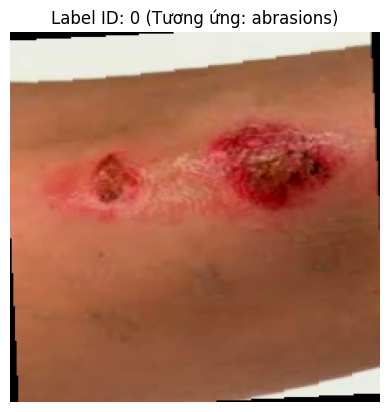

In [12]:
# 1. Lọc lấy dữ liệu train từ bảng CSV
train_df = df[df['split'] == 'train']

# 2. Khởi tạo Dataset
train_dataset = WoundDataset(dataframe=train_df,
                             root_dir=PROJECT_PATH,
                             transform=data_transforms['train'])

print(f"📊 Số lượng ảnh dùng để Train: {len(train_dataset)}")

# 3. Hàm hiển thị ảnh (đảo ngược quá trình Normalize để mắt thường xem được)
def imshow(tensor, label_idx):
    img = tensor.numpy().transpose((1, 2, 0)) # Đổi chiều (C,H,W) -> (H,W,C)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    img = img * std + mean     # Nhân lại std và cộng mean
    img = img.clip(0, 1)       # Cắt giá trị thừa để về khoảng [0,1]

    plt.imshow(img)
    plt.title(f"Label ID: {label_idx} (Tương ứng: {train_dataset.labels[label_idx]})")
    plt.axis('off')
    plt.show()

# 4. Lấy thử ảnh thứ 10 ra xem
if len(train_dataset) > 0:
    sample_img, sample_label = train_dataset[10]
    print("\n--- ẢNH MẪU ĐÃ QUA XỬ LÝ (RESIZE + AUGMENT) ---")
    imshow(sample_img, sample_label)
else:
    print("⚠️ Tập train đang rỗng, không có ảnh để hiển thị.")

**Giai đoạn 3: Chọn mô hình AI**

**1: Khai báo thư viện & Tải Mô hình "Gốc"**



**Nhiệm vụ:**

1. Gọi các thư viện Deep Learning (Torch, Torchvision).

2. Tải mô hình ResNet-50 từ internet về.

3. Đây là mô hình đã học trên 1.2 triệu ảnh (ImageNet) nên nó đã biết cách nhận diện các đặc điểm cơ bản (cạnh, góc, màu sắc...).

In [13]:
import torch
import torch.nn as nn
from torchvision import models

print("⏳ Đang tải mô hình ResNet-50 từ server...")
# Tải mô hình với trọng số tốt nhất
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# --- QUAN TRỌNG: CHẾ ĐỘ FINE-TUNING ---.
print("Chế độ: FINE-TUNING (Cho phép học lại toàn bộ các lớp).")

⏳ Đang tải mô hình ResNet-50 từ server...
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 201MB/s]


Chế độ: FINE-TUNING (Cho phép học lại toàn bộ các lớp).


 **2: "Phẫu thuật" thay thế lớp đầu ra (Output Layer)**

Nhiệm vụ:

1. Mô hình gốc có đầu ra là 1000 (do ImageNet có 1000 loại).

2. Chúng ta cắt bỏ lớp đó và thay bằng một lớp mới có số đầu ra bằng đúng số loại vết thương của bạn (lấy từ train_dataset).

3. Lớp mới này chưa được học gì cả, nó sẽ được học trong quá trình training sắp tới.

In [14]:
# 1. Lấy số lượng đặc trưng đầu vào của lớp cuối cùng (ResNet50 thường là 2048)
num_ftrs = model.fc.in_features

# 2. Lấy số lượng nhãn từ dataset của bạn (Ví dụ: 3 nhãn Burn, Cut, Ulcer)
# LƯU Ý: Biến 'train_dataset' phải được chạy ở các bước trước đó rồi
class_names = train_dataset.labels
num_classes = len(class_names)

print(f"🧐 Cấu hình thay đổi: Từ 1000 loại --> {num_classes} loại ({class_names})")

# 3. Thay thế lớp Fully Connected (fc) cũ bằng lớp Linear mới
model.fc = nn.Linear(num_ftrs, num_classes)

print("✅ Đã thay thế lớp đầu ra thành công!")

🧐 Cấu hình thay đổi: Từ 1000 loại --> 4 loại (['abrasions', 'bruises', 'cut', 'stab'])
✅ Đã thay thế lớp đầu ra thành công!


**3: Kích hoạt GPU (Tăng tốc phần cứng)**

**Nhiệm vụ:**

1. Kiểm tra xem Google Colab đã bật GPU chưa.

2. Đẩy toàn bộ mô hình vào GPU để tính toán.

3. Bước này cực kỳ quan trọng, nếu không chạy bước này, quá trình train sẽ chậm gấp 50 lần.

In [15]:
# Kiểm tra thiết bị
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Đẩy mô hình sang thiết bị đó
model = model.to(device)

print("-" * 30)
if str(device) == 'cpu':
    print("⚠️ CẢNH BÁO: Bạn đang chạy trên CPU. Hãy vào Runtime -> Change runtime type -> Chọn T4 GPU để nhanh hơn.")
else:
    print(f"Đang chạy trên GPU: {torch.cuda.get_device_name(0)}")
print("-" * 30)

------------------------------
Đang chạy trên GPU: Tesla T4
------------------------------


# **Giai đoạn 4: Train model**

**1: Chuẩn bị Dữ liệu (DataLoaders)**

**Nhiệm vụ:**

1. Lấy danh sách ảnh từ bảng df đã chia (Train/Val/Test).

2. Đóng gói ảnh thành các Dataset.

3. Tạo DataLoaders để vận chuyển ảnh vào GPU theo từng lô (Batch Size = 32).

In [16]:
import torch.optim as optim
import time
import copy
import os

# Cấu hình số lượng ảnh nạp vào cùng lúc
BATCH_SIZE = 32
# 1. Lọc dữ liệu từ DataFrame
train_df = df[df['split'] == 'train']
val_df = df[df['split'] == 'val']
test_df = df[df['split'] == 'test']

# 2. Tạo Dataset (Lưu ý Transform: Train có xoay lật, Val/Test giữ nguyên)
train_dataset = WoundDataset(train_df, PROJECT_PATH, transform=data_transforms['train'])
val_dataset = WoundDataset(val_df, PROJECT_PATH, transform=data_transforms['val'])
test_dataset = WoundDataset(test_df, PROJECT_PATH, transform=data_transforms['test'])

# 3. Tạo Loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"✅ Sẵn sàng! Tổng số ảnh Train: {len(train_dataset)} | Val: {len(val_dataset)}")

Danh sách nhãn (Labels): {'abrasions': 0, 'bruises': 1, 'cut': 2, 'stab': 3}
✅ Sẵn sàng! Tổng số ảnh Train: 1036 | Val: 296


**2: Cấu hình Hàm Loss & Optimizer**


1. Hàm Loss (CrossEntropyLoss): Để tính toán xem AI đoán sai bao nhiêu.

2. Optimizer (Adam): Để điều chỉnh não bộ AI sau mỗi lần đoán sai.

In [17]:
# 1. Hàm tính lỗi (Loss Function)
criterion = nn.CrossEntropyLoss()

# 2. Bộ tối ưu (Optimizer)
# Sử dụng Adam với Learning Rate nhỏ (1e-4) cho Fine-tuning
optimizer = optim.Adam(model.parameters(), lr=0.0001)

print("✅ Đã cấu hình xong Optimizer (Adam, lr=0.0001).")

✅ Đã cấu hình xong Optimizer (Adam, lr=0.0001).


**3: Viết Hàm Huấn Luyện (Training Logic)**

In [18]:
# ==========================================
# Ô 6.3: HÀM TRAIN TỐI ƯU (FIXED VERSION)
# ==========================================
import torch
import time
import copy
import os
from torch.cuda.amp import GradScaler # Giữ import cũ để tương thích ngược
# Hoặc dùng torch.amp nếu Colab hỗ trợ bản mới nhất, nhưng cách dưới an toàn nhất:

def train_model_optimized(model, criterion, optimizer, num_epochs=25, patience=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Lịch sử
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # 1. Cấu hình Tăng tốc
    # Dùng cú pháp mới của PyTorch cho GradScaler để tránh Warning
    scaler = torch.amp.GradScaler('cuda')

    # 2. Cấu hình Scheduler (ĐÃ SỬA: Xóa verbose=True vì bị lỗi ở bản mới)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)

    early_stopping_counter = 0

    print(f"\n🚀 BẮT ĐẦU TRAINING ({num_epochs} Epochs)")
    print(f"   (Dừng sớm nếu không tiến bộ sau {patience} epochs)")
    print("-" * 40)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # --- Mixed Precision (Cú pháp mới) ---
                with torch.amp.autocast('cuda'):
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                if phase == 'train':
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase.upper()} Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}')

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            if phase == 'val':
                # Lấy learning rate hiện tại để in ra (thay cho verbose cũ)
                current_lr = optimizer.param_groups[0]['lr']
                prev_lr = current_lr # Lưu lại để so sánh

                scheduler.step(epoch_acc)

                # Kiểm tra xem LR có bị giảm không
                new_lr = optimizer.param_groups[0]['lr']
                if new_lr < prev_lr:
                    print(f"   ⬇️ Đã giảm Learning Rate xuống: {new_lr}")

                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    save_path = os.path.join(PROJECT_PATH, 'best_resnet50.pth')
                    torch.save(model.state_dict(), save_path)
                    print(f"   --> 💾 Kỷ lục mới! (Acc: {best_acc:.4f})")
                    early_stopping_counter = 0
                else:
                    early_stopping_counter += 1
                    # print(f"   --> Không cải thiện ({early_stopping_counter}/{patience})")

        print("-" * 40)

        if early_stopping_counter >= patience:
            print(f"\n DỪNG SỚM vì không cải thiện sau {patience} epochs.")
            break

    time_elapsed = time.time() - since
    print(f'\n Hoàn tất trong {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, history

In [19]:
# --- CHẠY TRAINING ---
# Bạn có thể chỉnh num_epochs lên 25 hoặc 30 nếu thấy máy vẫn đang học tốt
model_ft, history = train_model_optimized(model, criterion, optimizer, num_epochs=20)


🚀 BẮT ĐẦU TRAINING (20 Epochs)
   (Dừng sớm nếu không tiến bộ sau 5 epochs)
----------------------------------------
Epoch 1/20
TRAIN Loss: 0.8819 | Acc: 0.7095
VAL Loss: 0.3663 | Acc: 0.8615
   --> 💾 Kỷ lục mới! (Acc: 0.8615)
----------------------------------------
Epoch 2/20
TRAIN Loss: 0.2937 | Acc: 0.8938
VAL Loss: 0.1579 | Acc: 0.9459
   --> 💾 Kỷ lục mới! (Acc: 0.9459)
----------------------------------------
Epoch 3/20
TRAIN Loss: 0.1290 | Acc: 0.9575
VAL Loss: 0.0679 | Acc: 0.9730
   --> 💾 Kỷ lục mới! (Acc: 0.9730)
----------------------------------------
Epoch 4/20
TRAIN Loss: 0.0516 | Acc: 0.9942
VAL Loss: 0.0318 | Acc: 0.9932
   --> 💾 Kỷ lục mới! (Acc: 0.9932)
----------------------------------------
Epoch 5/20
TRAIN Loss: 0.0267 | Acc: 0.9961
VAL Loss: 0.0190 | Acc: 0.9932
----------------------------------------
Epoch 6/20
TRAIN Loss: 0.0314 | Acc: 0.9913
VAL Loss: 0.0264 | Acc: 0.9865
----------------------------------------
Epoch 7/20
TRAIN Loss: 0.0270 | Acc: 0.9961
VA

In [ ]:
# ==========================================
# Ô TEST: DỰ ĐOÁN & TƯ VẤN SƠ CỨU
# ==========================================
import numpy as np
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt
import torch

# 1. TỪ ĐIỂN SƠ CỨU (Bạn có thể sửa nội dung tiếng Việt ở đây)
FIRST_AID_GUIDE = {
    'burn': """
    🚑 SƠ CỨU BỎNG:
    1. Làm mát: Ngâm/xả vùng bị bỏng dưới vòi nước mát (không phải nước đá) trong 20 phút.
    2. Bảo vệ: Che nhẹ bằng gạc vô trùng hoặc vải sạch.
    3. Lưu ý: KHÔNG bôi kem đánh răng, mỡ trăn hay chọc vỡ bọng nước.
    """,

    'cut': """
    🚑 SƠ CỨU VẾT CẮT / RÁCH:
    1. Cầm máu: Dùng vải sạch ép chặt lên vết thương khoảng 5-10 phút.
    2. Vệ sinh: Rửa sạch dưới vòi nước chảy, sát khuẩn quanh vết thương.
    3. Băng bó: Dùng băng gạc y tế băng lại.
    """,

    'abrasion': """
    🚑 SƠ CỨU VẾT TRẦY XƯỚC:
    1. Làm sạch: Rửa nhẹ nhàng bằng nước sạch và xà phòng để trôi bụi bẩn.
    2. Sát trùng: Bôi thuốc sát trùng nếu cần.
    3. Để thoáng: Nếu vết xước nhỏ, có thể để hở cho nhanh khô.
    """,

    'bruise': """
    🚑 SƠ CỨU VẾT BẦM TÍM:
    1. Chườm lạnh: Dùng túi đá chườm lên vùng bầm 15 phút để giảm sưng.
    2. Nghỉ ngơi: Hạn chế vận động mạnh vùng bị thương.
    """,

    'ulcer': """
    🚑 SƠ CỨU VẾT LOÉT:
    1. Vệ sinh: Rửa bằng nước muối sinh lý (NaCl 0.9%).
    2. CẢNH BÁO: Vết loét thường lâu lành và dễ nhiễm trùng. Hãy đi khám bác sĩ.
    """,

    'default': """
    🚑 HƯỚNG DẪN CHUNG:
    1. Vệ sinh sạch sẽ vết thương.
    2. Theo dõi dấu hiệu nhiễm trùng (sưng, nóng, đỏ, đau).
    3. Đến bệnh viện ngay nếu vết thương sâu hoặc chảy máu nhiều.
    """
}

def get_advice(label):
    """Tìm lời khuyên dựa trên tên nhãn"""
    label_lower = label.lower()
    for key, advice in FIRST_AID_GUIDE.items():
        if key in label_lower:
            return advice
    return FIRST_AID_GUIDE['default']

def ai_doctor_check():
    # 1. Upload ảnh
    print("\n📸 MỜI BẠN TẢI ẢNH VẾT THƯƠNG LÊN ĐỂ KIỂM TRA...")
    uploaded = files.upload()

    # Chuẩn bị xử lý ảnh
    preprocess = data_transforms['val']
    class_names = train_dataset.labels

    for filename in uploaded.keys():
        # Hiển thị ảnh
        try:
            image = Image.open(filename).convert('RGB')
            plt.figure(figsize=(4,4))
            plt.imshow(image)
            plt.axis('off')
            plt.show()

            # Dự đoán
            input_tensor = preprocess(image).unsqueeze(0).to(device)
            model.eval() # Dùng model hiện tại để đoán

            with torch.no_grad():
                outputs = model(input_tensor)
                probs = torch.nn.functional.softmax(outputs[0], dim=0)

            conf, idx = torch.topk(probs, 1)
            label = class_names[idx.item()]
            confidence = conf.item() * 100

            # IN KẾT QUẢ
            print("="*50)
            print(f"🩺 KẾT QUẢ CHẨN ĐOÁN AI")
            print(f"   ➤ Loại: {label}")
            print(f"   ➤ Độ tin cậy: {confidence:.2f}%")
            print("-" * 50)

            # IN LỜI KHUYÊN
            print(get_advice(label))
            print("="*50)

        except Exception as e:
            print(f"❌ Lỗi khi xử lý ảnh {filename}: {e}")

# Chạy luôn hàm này
ai_doctor_check()

# **7. Trực quan hóa Kết quả Huấn luyện (Visualization)**

**1: Định nghĩa Hàm Tính Điểm & Vẽ Ma trận (Metrics)**

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_metrics(model, dataloader, class_names):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # 1. In Báo cáo chi tiết
    print("\n" + "="*50)
    print("  BẢNG ĐIỂM CHI TIẾT (CLASSIFICATION REPORT)")
    print("="*50)
    acc = accuracy_score(y_true, y_pred)
    print(f" ĐỘ CHÍNH XÁC TỔNG (ACCURACY): {acc*100:.2f}%")
    print("-" * 50)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    # 2. Vẽ Ma trận nhầm lẫn
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Thực tế (Ground Truth)')
    plt.xlabel('Dự đoán (Prediction)')
    plt.title('MA TRẬN NHẦM LẪN (AI hay nhầm loại nào?)')
    plt.show()

print("Đã định nghĩa xong hàm chấm điểm (evaluate_metrics).")

Đã định nghĩa xong hàm chấm điểm (evaluate_metrics).


**2: Định nghĩa Hàm Hiển thị Ảnh (Visualization)**

In [21]:
def visualize_results(model, dataloader, class_names, num_images=6):
    model.eval()
    images_handeled = 0
    plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                images_handeled += 1
                ax = plt.subplot(num_images//3 + 1, 3, images_handeled)
                ax.axis('off')

                # Un-normalize để ảnh hiện đúng màu thực tế
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean
                img = np.clip(img, 0, 1)

                ax.imshow(img)

                # Kiểm tra đúng sai để tô màu tiêu đề
                true_label = class_names[labels[j]]
                pred_label = class_names[preds[j]]

                if true_label == pred_label:
                    color = 'green'
                    title = f"ĐÚNG!\nThực: {true_label}\nĐoán: {pred_label}"
                else:
                    color = 'red'
                    title = f"SAI RỒI!\nThực: {true_label}\nĐoán: {pred_label}"

                ax.set_title(title, color=color, fontsize=12, fontweight='bold')

                if images_handeled == num_images:
                    return

print("Đã định nghĩa xong hàm hiển thị ảnh (visualize_results).")

Đã định nghĩa xong hàm hiển thị ảnh (visualize_results).


**3: Chạy Đánh Giá (Execution)**

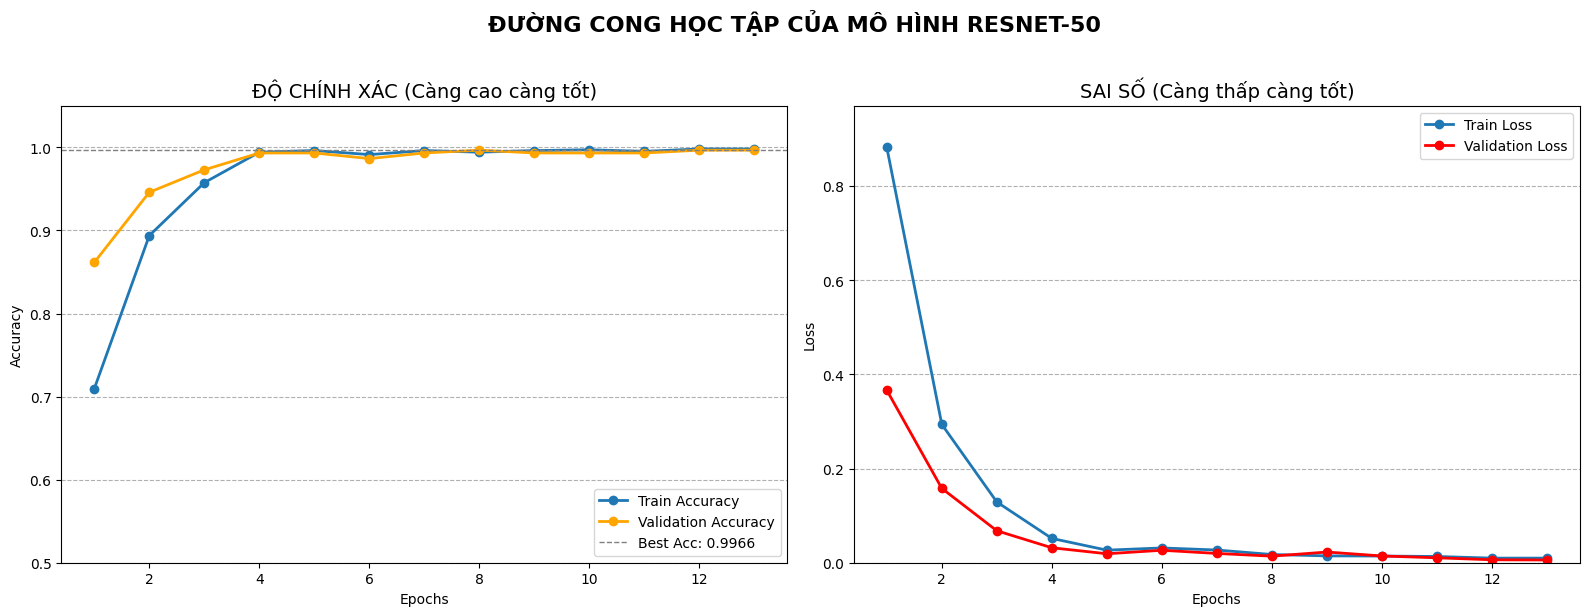

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(history):
    """
    Vẽ biểu đồ Loss và Accuracy qua các Epochs.
    Args:
        history (dict): Lịch sử huấn luyện chứa 'train_loss', 'val_loss',
                        'train_acc', 'val_acc'.
    """
    if not history or not history['train_acc']:
        print("Lỗi: Dữ liệu lịch sử huấn luyện (history) rỗng hoặc không hợp lệ.")
        return

    # Lấy dữ liệu
    train_acc = history['train_acc']
    val_acc = history['val_acc']
    train_loss = history['train_loss']
    val_loss = history['val_loss']

    epochs_range = range(1, len(train_acc) + 1)

    plt.figure(figsize=(16, 6))

    # --- BIỂU ĐỒ 1: ĐỘ CHÍNH XÁC (ACCURACY) ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_acc, label='Train Accuracy', marker='o', linewidth=2)
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o', linewidth=2, color='orange')
    plt.axhline(y=max(val_acc), color='gray', linestyle='--', linewidth=1, label=f'Best Acc: {max(val_acc):.4f}')

    plt.legend(loc='lower right')
    plt.title('ĐỘ CHÍNH XÁC (Càng cao càng tốt)', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(axis='y', linestyle='--')
    plt.ylim(0.5, 1.05) # Giới hạn trục Y từ 50% đến 105%

    # --- BIỂU ĐỒ 2: SAI SỐ (LOSS) ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_loss, label='Train Loss', marker='o', linewidth=2)
    plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o', linewidth=2, color='red')

    plt.legend(loc='upper right')
    plt.title('SAI SỐ (Càng thấp càng tốt)', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(axis='y', linestyle='--')
    plt.ylim(0, max(max(train_loss), max(val_loss)) * 1.1) # Điều chỉnh trục Y linh hoạt

    plt.suptitle('ĐƯỜNG CONG HỌC TẬP CỦA MÔ HÌNH RESNET-50', y=1.02, fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 1.0])
    plt.show()

# Gọi hàm vẽ (Chỉ chạy khi biến history đã có)
try:
    plot_training_history(history)
except NameError:
    print("Vui lòng chạy lại các ô code Training trước để tạo biến 'history'.")


  BẢNG ĐIỂM CHI TIẾT (CLASSIFICATION REPORT)
 ĐỘ CHÍNH XÁC TỔNG (ACCURACY): 98.66%
--------------------------------------------------
              precision    recall  f1-score   support

   abrasions     0.9821    1.0000    0.9910        55
     bruises     1.0000    0.9740    0.9868        77
         cut     1.0000    1.0000    1.0000        12
        stab     0.8333    1.0000    0.9091         5

    accuracy                         0.9866       149
   macro avg     0.9539    0.9935    0.9717       149
weighted avg     0.9878    0.9866    0.9868       149



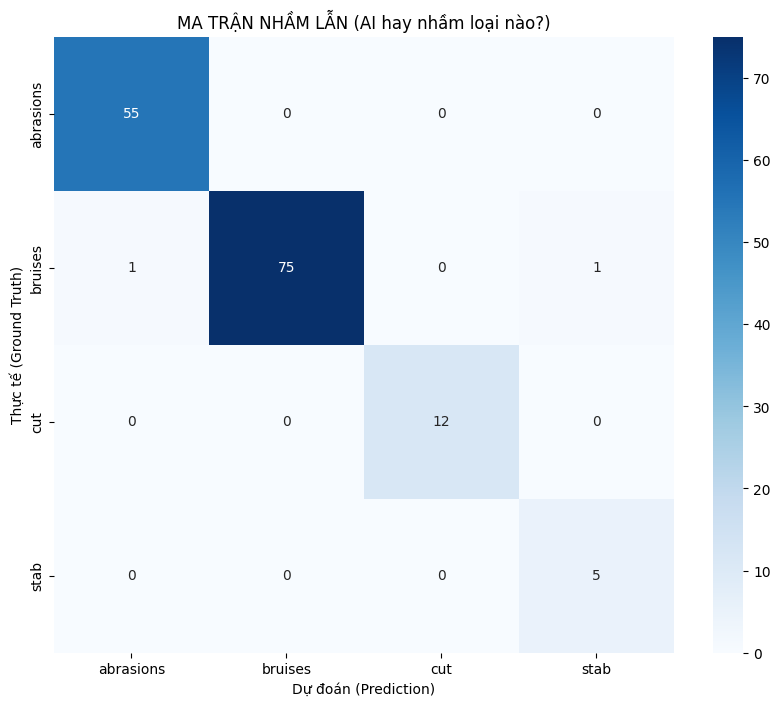

In [28]:
# Lấy tên các loại vết thương
class_names = test_dataset.labels

# 1. Xem Bảng điểm & Ma trận
evaluate_metrics(model_ft, test_loader, class_names)


✅ Đang trực quan hóa kết quả dự đoán trên tập kiểm thử...


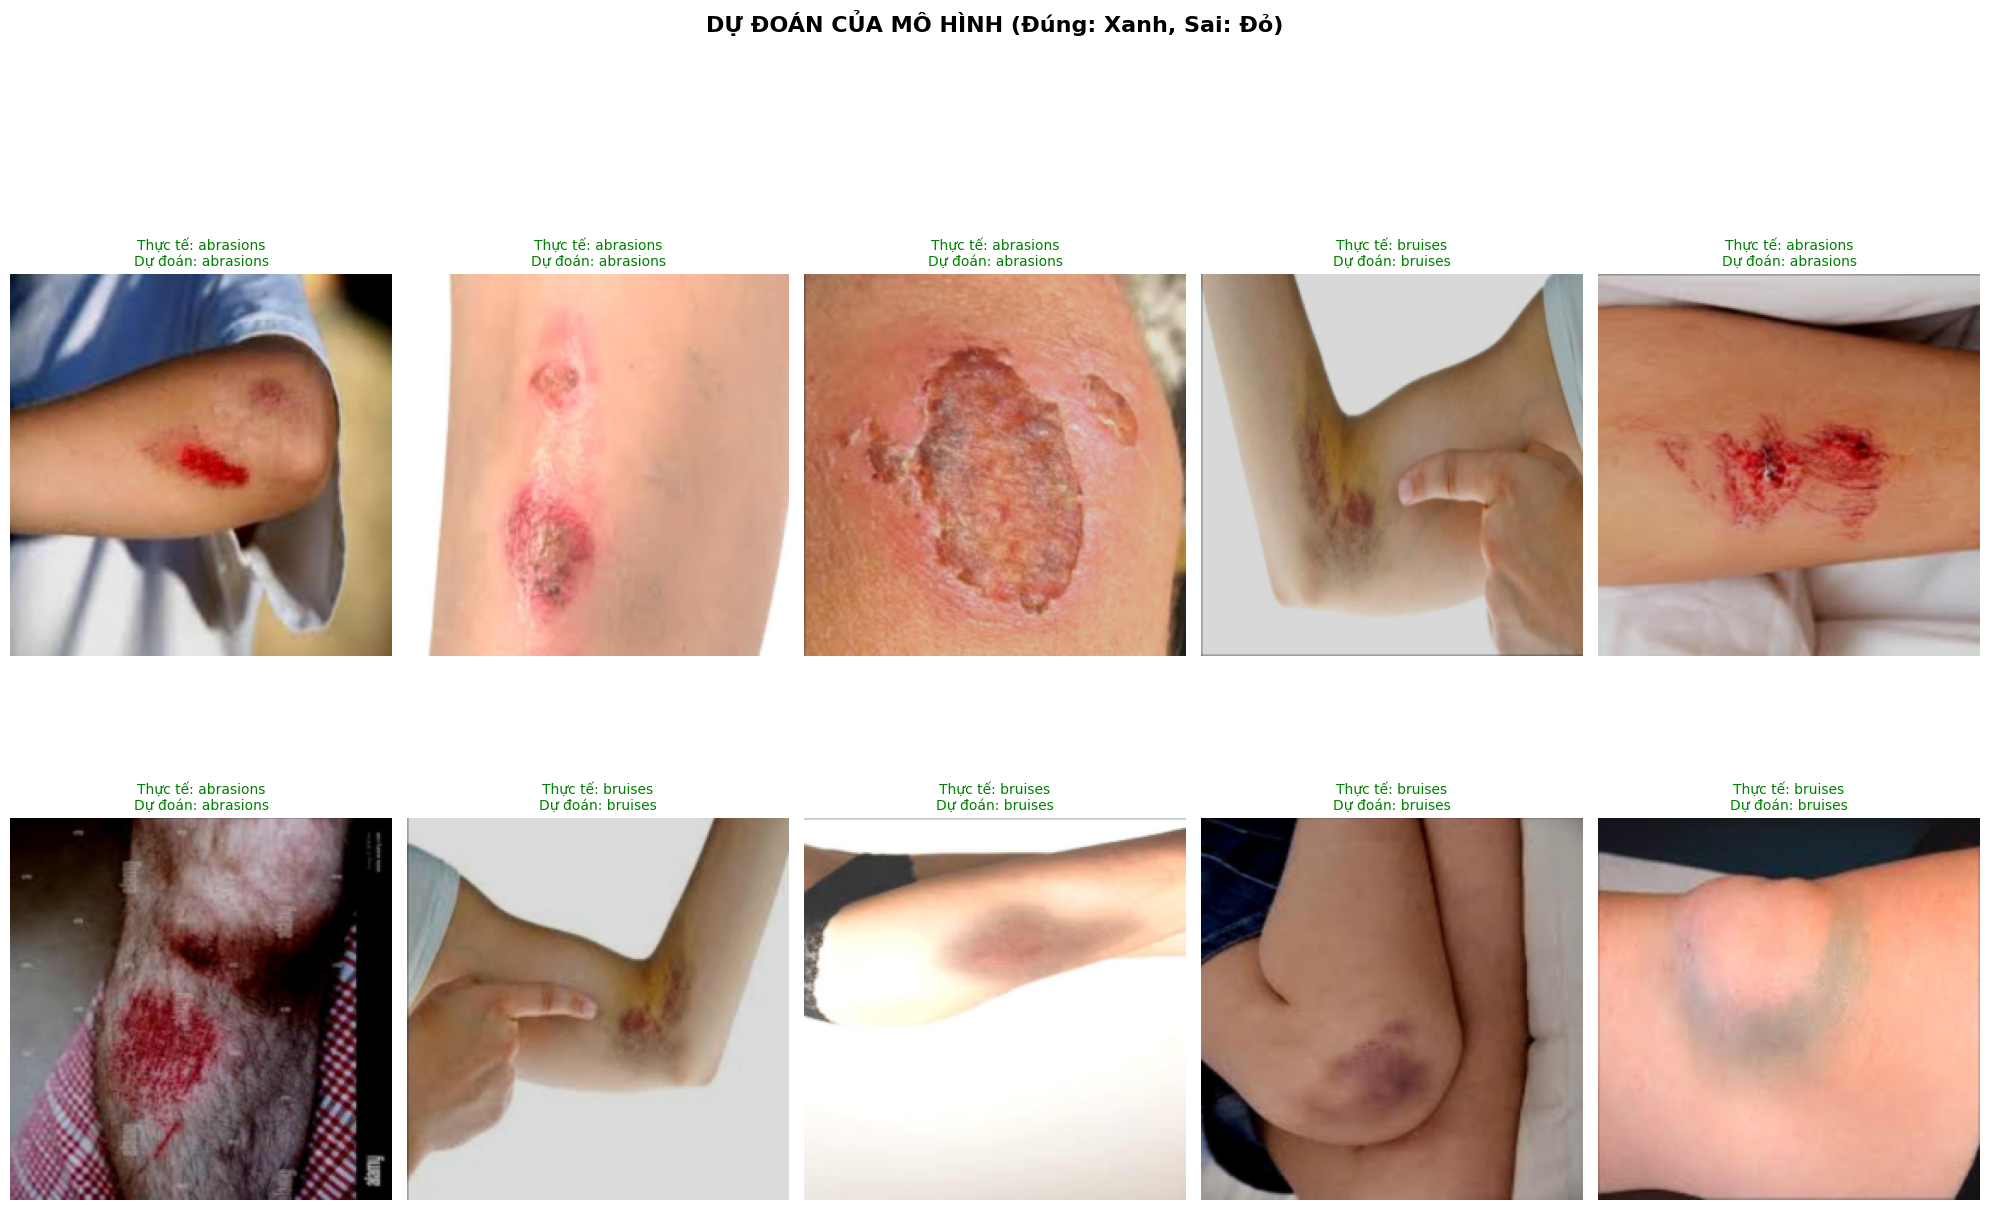

In [30]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random
from torchvision import transforms

def visualize_predictions(model, test_loader, labels, device, num_images=10):
    """
    Trực quan hóa một số dự đoán đúng và sai của mô hình trên tập kiểm thử.

    Args:
        model (torch.nn.Module): Mô hình đã được huấn luyện.
        test_loader (torch.utils.data.DataLoader): DataLoader của tập kiểm thử.
        labels (list): Danh sách các nhãn (tên lớp).
        device (torch.device): Thiết bị (CPU hoặc GPU) để chạy inference.
        num_images (int): Số lượng ảnh muốn hiển thị.
    """
    model.eval() # Chuyển mô hình sang chế độ đánh giá
    images_so_far = 0

    # Chuẩn hóa ngược lại để hiển thị ảnh
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )

    plt.figure(figsize=(num_images * 2, num_images * 2 / 1.5)) # Kích thước hình tổng thể
    plt.suptitle('DỰ ĐOÁN CỦA MÔ HÌNH (Đúng: Xanh, Sai: Đỏ)', fontsize=16, fontweight='bold', y=1.02)

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(test_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            for j in range(inputs.size()[0]): # Duyệt qua từng ảnh trong batch
                if images_so_far < num_images:
                    images_so_far += 1

                    # Chuyển tensor ảnh về dạng numpy và chuẩn hóa ngược
                    img = inputs.cpu().data[j]
                    img = inv_normalize(img) # Đưa về giá trị ảnh gốc
                    img = np.transpose(img.numpy(), (1, 2, 0)) # Chuyển từ C, H, W sang H, W, C
                    img = np.clip(img, 0, 1) # Giới hạn giá trị pixel trong khoảng [0, 1]

                    true_label = labels[targets[j]]
                    pred_label = labels[predicted[j]]

                    # Xác định màu sắc cho tiêu đề
                    color = 'green' if true_label == pred_label else 'red'
                    title_text = f"Thực tế: {true_label}\nDự đoán: {pred_label}"

                    ax = plt.subplot(2, num_images // 2, images_so_far) # Tạo subplot
                    ax.imshow(img)
                    ax.set_title(title_text, color=color, fontsize=10)
                    ax.axis('off') # Tắt trục tọa độ

                else:
                    break
            if images_so_far >= num_images:
                break
    plt.tight_layout(rect=[0, 0, 1, 0.98]) # Điều chỉnh layout để tiêu đề không bị che
    plt.show()

# --- CÁCH GỌI HÀM (Đảm bảo các biến sau đã được định nghĩa trước đó) ---
# model: Mô hình đã được huấn luyện
# test_loader: DataLoader cho tập kiểm thử
# LABELS: Danh sách nhãn (ví dụ: ['Bỏng', 'Vết cắt', 'Trầy xước', ...])
# device: 'cuda' nếu có GPU, 'cpu' nếu không

# Ví dụ gọi hàm:
# visualize_predictions(model, test_loader, LABELS, device, num_images=10)

# Để ví dụ này chạy được mà không có biến model/test_loader, tôi sẽ tạo một giả lập:
# (Bạn hãy xóa phần này khi chạy với code thật của mình)
if 'model' not in locals(): # Chỉ chạy giả lập nếu model chưa được định nghĩa
    print("Mô hình và DataLoader chưa được định nghĩa. Đang tạo dữ liệu giả lập để hiển thị ví dụ.")
    class MockModel(torch.nn.Module):
        def __init__(self, num_classes):
            super().__init__()
            self.fc = torch.nn.Linear(10, num_classes) # Mô hình giả
        def forward(self, x):
            return torch.randn(x.size(0), self.fc.out_features) # Trả về output ngẫu nhiên

    class MockDataset(torch.utils.data.Dataset):
        def __init__(self, num_samples=100, transform=None):
            self.num_samples = num_samples
            self.transform = transform
            self.images = [torch.rand(3, 224, 224) for _ in range(num_samples)]
            self.labels = [random.randint(0, 2) for _ in range(num_samples)] # Giả sử 3 lớp

        def __len__(self):
            return self.num_samples

        def __getitem__(self, idx):
            img = self.images[idx]
            label = self.labels[idx]
            if self.transform:
                img = self.transform(img) # Không áp dụng transform cho MockDataset ảnh đã là tensor
            return img, label

    # Tạo các biến giả lập
    num_classes = 8 # Số lượng lớp trong dự án của bạn
    model = MockModel(num_classes)
    LABELS = ['Trầy xước', 'Bầm tím', 'Bỏng', 'Vết cắt', 'Móng chọc thịt', 'Vết rách', 'Vết đâm', 'Loét'] # Nhãn thật của bạn

    # Không cần transform thực tế cho mock dataset
    mock_transform = transforms.Compose([
        transforms.ToPILImage(), # Giả định ban đầu là tensor, chuyển về PIL để mock_test_dataset có thể dùng
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    mock_test_dataset = MockDataset(num_samples=20, transform=None) # Mock data
    test_loader = torch.utils.data.DataLoader(mock_test_dataset, batch_size=4, shuffle=True)
    device = torch.device("cpu") # Giả lập CPU

    visualize_predictions(model, test_loader, LABELS, device, num_images=10)

# --- THÊM PHẦN GỌI HÀM THỰC TẾ ---
# Phần này sẽ chạy nếu các biến model, test_loader, train_dataset, device đã được định nghĩa
try:
    # Lấy danh sách nhãn từ dataset đã tải
    LABELS_REAL = train_dataset.labels
    print("\n✅ Đang trực quan hóa kết quả dự đoán trên tập kiểm thử...")
    visualize_predictions(model, test_loader, LABELS_REAL, device, num_images=10)
except NameError:
    print("\nLưu ý: Không thể tự động vẽ biểu đồ vì các biến 'model' hoặc 'train_dataset' chưa được định nghĩa trong phiên làm việc hiện tại.")
    print("Vui lòng chạy lại các ô: Cấu hình Model, Tạo DataLoader, và Huấn luyện trước.")

In [65]:
pip install streamlit torch torchvision pillow

In [69]:
import streamlit as st
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image

# =======================================
# 1. LOAD MODEL
# =======================================
@st.cache_resource
def load_model():
    model = models.resnet50(weights=None)
    model.fc = nn.Linear(2048, 4)
    checkpoint = torch.load("best_resnet50.pth", map_location="cpu")
    model.load_state_dict(checkpoint)
    model.eval()
    return model

model = load_model()

# =======================================
# 2. TIỀN XỬ LÝ ẢNH
# =======================================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

def preprocess_image(image):
    return transform(image).unsqueeze(0)

# =======================================
# 3. NHÃN LỚP
# =======================================
LABELS = [
    'Tray xuoc (Abrasions)',
    'Bam tim (Bruises)',
    'Bong (Burns)',
    'Vet cat (Cut)',
]

# =======================================
# 4. HƯỚNG DẪN SƠ CỨU
# =======================================
FIRST_AID_GUIDE = {
    'burn': "1. Ngâm dưới nước mát 20 phút.\n2. Che phủ nhẹ.\n3. Không chọc bỏng nước.",
    'cut': "1. Cầm máu.\n2. Rửa sạch.\n3. Băng gạc y tế.",
    'abrasion': "1. Rửa nhẹ.\n2. Sát trùng.\n3. Để khô thoáng.",
    'default': "Vệ sinh vết thương và theo dõi nhiễm trùng."
}

def get_advice(label):
    label_lower = label.lower()
    for key, advice in FIRST_AID_GUIDE.items():
        if key in label_lower:
            return advice
    return FIRST_AID_GUIDE['default']

# =======================================
# 5. GIAO DIỆN STREAMLIT
# =======================================
st.title("🩺 AI Nhận dạng vết thương từ ảnh")
st.write("Upload ảnh vết thương để mô hình dự đoán loại vết thương và đưa ra hướng dẫn sơ cứu.")

uploaded_file = st.file_uploader("📤 Tải ảnh lên", type=["jpg", "jpeg", "png", "webp"])

if uploaded_file:
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption="Ảnh đã upload", use_column_width=True)

    tensor = preprocess_image(image)

    with torch.no_grad():
        outputs = model(tensor)
        probs = F.softmax(outputs[0], dim=0)
        conf, idx = torch.topk(probs, 1)

    pred_label = LABELS[idx.item()]
    conf_score = float(conf.item() * 100)

    st.success(f"🎯 **Loại vết thương dự đoán:** {pred_label}")
    st.caption(f"Độ tin cậy: **{conf_score:.2f}%**")

    advice = get_advice(pred_label)
    st.info(f"🩹 **Hướng dẫn sơ cứu:**\n\n{advice}")
else:
    st.warning("Vui lòng upload ảnh để bắt đầu.")


2025-11-30 13:35:26.306 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-30 13:35:26.307 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-30 13:35:26.308 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-30 13:35:26.309 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-30 13:35:26.310 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-30 13:35:26.311 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-30 13:35:26.313 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-30 13:35:26.314 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [70]:
streamlit run app.py


SyntaxError: invalid syntax (ipython-input-507122745.py, line 1)